# 120066 Utilities, Plots, and Analysis 

- restore MCMC results, performed at the command line
    - I suggest you run the MCMC by running `radvel mcmc -s 120066.py -d 2018-5-17` in the 120066 Dropbox directory (replace with current date)
- preview plots & save them to a new directory named for the current date in the 120066 Dropbox
- upload plots to an Overleaf paper file

### To run this notebook:
- make sure you have the Dropbox Desktop app installed, and that the path to your copy of the 120066 Dropbox directory is `~/Dropbox/120066_radvel`
- make sure you have `radvel` (v1.2.7) and `orbitize` installed (`pip install orbitize radvel --upgrade`). 
- Sync your Dropbox and Overleaf accounts.


# Preliminary Imports & Setup

In [1]:
import numpy as np
import datetime
import pandas as pd
import os

from scipy import optimize

from astropy.time import Time
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u

from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

import corner

import radvel
from radvel.plot import orbit_plots, mcmc_plots
from radvel.driver import load_status
from radvel.mcmc import gelman_rubin

from orbitize.kepler import calc_orbit

import lambertian_contrast as lambc

%pylab inline
rcParams['font.size'] = 18

# change to the directory where all the action is
os.chdir(os.environ['HOME'] + '/Dropbox/planet-pi')

today = '2019-7-26'
todays_directory = today + '/master'

# read in data
data_cps = pd.read_csv('~/Dropbox/planet-pi/data/120066.txt')
data_mcd = pd.read_csv(
    '~/Dropbox/planet-pi/data/HD120066_McD.ALL',
    names=['time','mnvel','errvel','SVAL','sval_err'], 
    header=None,
    sep='\s+'
)
data_mcd['tel']='m'
mcd_time_offset = 40000.
data_mcd['time'] -= mcd_time_offset

# add Tull S values
svals_mcd = np.transpose(np.loadtxt('data/vels.hr5183', skiprows=1, usecols=(1,2,3)))

for i in np.arange(len(data_mcd)):
    for j in np.arange(len(svals_mcd[0])):
        if np.abs(svals_mcd[0][j] - mcd_time_offset - data_mcd.time.values[i]) < .01:
            data_mcd['SVAL'][i] = svals_mcd[1][j]
            data_mcd['sval_err'][i] = svals_mcd[2][j]

data = pd.concat([data_cps, data_mcd], ignore_index=True)
time_offset_from_jd = 2440000.

# add on S values for pre-upgrade HIRES
svals_preupgrade = pd.read_csv('data/pre_upgrade_svals.csv', comment='#')
for i in np.arange(len(data[data.tel == 'k'])):
    for j in np.arange(len(svals_preupgrade)):
        if np.abs(svals_preupgrade.jd.values[j] - time_offset_from_jd - data.time.values[i]) < .01:
            data['SVAL'][i] = svals_preupgrade.sval[j]
            data['sval_err'][i] = 0.065*svals_preupgrade.sval[j] # 6.5% error on pre-upgrade svals (Wright+ 2004)
            
data_apf = data[data.tel == 'a']
data_j = data[data.tel == 'j']
data_k = data[data.tel == 'k']
data_hires = data[(data.tel == 'j') | (data.tel == 'k')]

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192


Populating the interactive namespace from numpy and matplotlib


# Restore MCMC chains & Posterior Object

In [2]:
post_file_name = os.path.join(
    os.environ['HOME'] + '/Dropbox/planet-pi/' 
    + todays_directory + '/','120066_post_obj.pkl'
)
chains_file_name = os.path.join(
    os.environ['HOME'] + '/Dropbox/planet-pi/' 
    + todays_directory + '/','120066_chains.csv.tar.bz2'
)

# read in chains
df = pd.read_csv(chains_file_name, compression='bz2')

# read in posterior object
post = radvel.posterior.load(post_file_name)

# Calculate Relevant Posteriors Not Fitted by MCMC

In [3]:
solrad2au = 0.00465047
mjup2msun = 0.0009543
rjup2rsun = 0.10276269
rad2as = 206265. # converts radians to arcsecs

# define stellar mass & error, parallax
mstar_measured = 1.09
mstar_err = 0.06

# parallax (mas) from Gaia - from CKS-Gaia Results
plx_measured = 31.49
plx_err = 0.04

# derive msini, semi-major axis, periastron passage distance posteriors
df_synth = post.params.basis.to_synth(df)
chain_length = len(df_synth['w1'])

tp = df_synth['tp1'].values
tp_mjd = tp + time_offset_from_jd - 2400000.5
per_days = df_synth['per1'].values
per_yr = per_days/365.25
semiamp = df_synth['k1'].values
ecc = df_synth['e1'].values
omega_rad = df_synth['w1'].values
omega_pl_rad = omega_rad + np.pi
omega_deg = omega_rad*180./np.pi

# draw from normally distributed stellar mass & parallax distributions
mstar = mstar_measured + np.random.normal(scale=mstar_err, size=chain_length)
parallax = plx_measured + np.random.normal(scale=plx_err, size=chain_length)

# calculate msini
msini = radvel.utils.Msini(
    semiamp, 
    per_days, 
    mstar, 
    ecc, Msini_units='jupiter'
)
   
# calculate sma (in au)
sma = radvel.utils.semi_major_axis(per_days, mstar)

# stellar Teff, R* from specmatch results
st_teff_med = 5794.
st_teff = np.random.normal(st_teff_med,100., size=chain_length)
rstar_med = 1.53
rstar_med_au = rstar_med*solrad2au
rstar = np.random.normal(rstar_med, 0.06, size=chain_length)
rstar_au = rstar*solrad2au

# calculate transit probability
jup_rad_au=0.000477895
transit_prob = ((rstar_au+jup_rad_au)/sma)*(1+ecc*np.sin(omega_pl_rad))/(1-ecc**2)

# calculate T_eq at apo and peri
peri_dist = sma * (1. - ecc)
apo_dist = sma * (1. + ecc)

albedo = 0.5

T_eq_peri = st_teff*np.sqrt(rstar_au/(2*peri_dist))*(1-albedo)**0.25
T_eq_apo = st_teff*np.sqrt(rstar_au/(2*apo_dist))*(1-albedo)**0.25

# define MAP params
per_map_days = post.maxparams['per1']
per_map_yr = per_map_days/365.25
semiamp_map = post.maxparams['k1']
ecc_map = post.maxparams['e1']
tp_map = post.maxparams['tp1']
tp_mjd_map = tp_map + time_offset_from_jd - 2400000.5
sma_map = radvel.utils.semi_major_axis(per_map_days, mstar_measured)
omega_map_rad = post.maxparams['w1']
omega_pl_map_rad = post.maxparams['w1'] + np.pi
K_map = np.exp(post.maxparams['logk1'])
peri_dist_map = sma_map * (1. - ecc_map)
apo_dist_map = sma_map * (1. + ecc_map)
map_T_eq_peri = st_teff_med*np.sqrt(rstar_med_au/(2*peri_dist_map))*(1-albedo)**0.25
map_T_eq_apo = st_teff_med*np.sqrt(rstar_med_au/(2*apo_dist_map))*(1-albedo)**0.25

msini_map = radvel.utils.Msini(
    semiamp_map,
    per_map_days, 
    mstar_measured, 
    ecc_map, Msini_units='jupiter'
)

# Make Some Plots!

### Trend Plot

In [4]:
saveas = todays_directory + '/120066_trend.pdf'
mcmcTrend = mcmc_plots.TrendPlot(post, df, 40, outfile=saveas)
mcmcTrend.plot()

Trend plot saved to 2019-7-26/master/120066_trend.pdf


### RV Multipanel Plot

In [5]:
# create annotations for plot
anotext = ''
units = {'P': 'yr', 'Msini': '$\\mathregular{M_J}$', 'e': ''}
val = {
    'P': per_map_yr, 
    'Msini': msini_map, 
    'e': ecc_map
}
for item in ['P', 'e', 'Msini']:
    anotext += '$\\mathregular{%s}$ = %4.2f %s\n' % (item, val[item], units[item])

RV multi-panel plot saved to 2019-7-26/master/120066_rvmultipanel.pdf


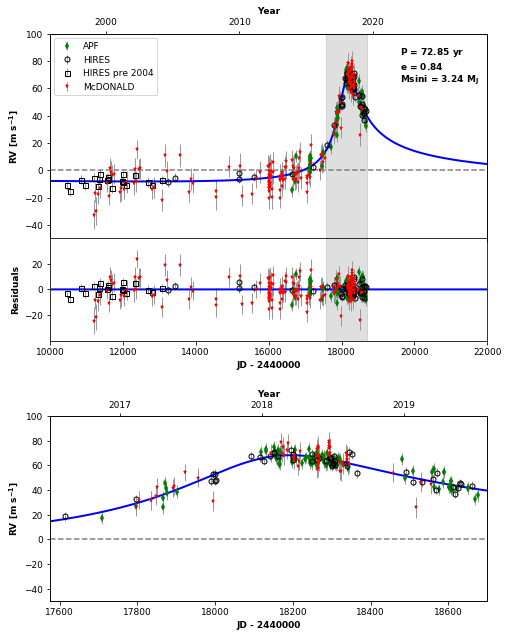

In [6]:
# preview & save RV multipanel plot
rcParams['font.size'] = 8

saveas = todays_directory + '/120066_rvmultipanel.pdf'

RVPlot = orbit_plots.MultipanelPlot(
    post, epoch=time_offset_from_jd, nobin=True, 
    saveplot= saveas, set_xlim=[10000.,22000.],
    telfmts= {
        'm': dict(color='red', fmt='*', label='McDONALD'),
        'j': dict(fmt='o', color='black', markerfacecolor='none', markeredgewidth=1.0, label='HIRES')
    }, yscale_auto=True, legend=False
)
fig, ax_list = RVPlot.plot_multipanel(nophase=True, letter_labels=False)
ax_list[0].legend(numpoints=1, loc='upper left')
sca(ax_list[0])
radvel.plot.add_anchored(
   anotext, loc='upper right', frameon=True, prop=dict(weight='bold'),
   bbox=dict(ec='none', fc='w', alpha=0.8)
)

fig.set_size_inches(7.5,9.)

zoom_xlim = [17575.,18700.]
ax_list[0].axvspan(zoom_xlim[0],zoom_xlim[1],alpha=0.25,color='grey')
ax_list[1].axvspan(zoom_xlim[0],zoom_xlim[1],alpha=0.25,color='grey')

RVPlot.set_xlim= zoom_xlim
gs_phase = gridspec.GridSpec(1,1)
gs_phase.update(
    left=0.12, right=0.93,
    top=0.34, hspace=0.003,
    bottom=0.055
)
ax_zoom = plt.subplot(gs_phase[0,0])
plt.sca(ax_zoom)
RVPlot.plot_timeseries()
plt.setp(ax_zoom.get_xticklabels(), visible=True)
_ = ax_zoom.set_xlabel('JD - {:d}'.format(int(np.round(time_offset_from_jd))), weight='bold')

plt.savefig(saveas, dpi=250)

### Corner Plot

Corner plot saved to 2019-7-26/master/120066_corner.pdf


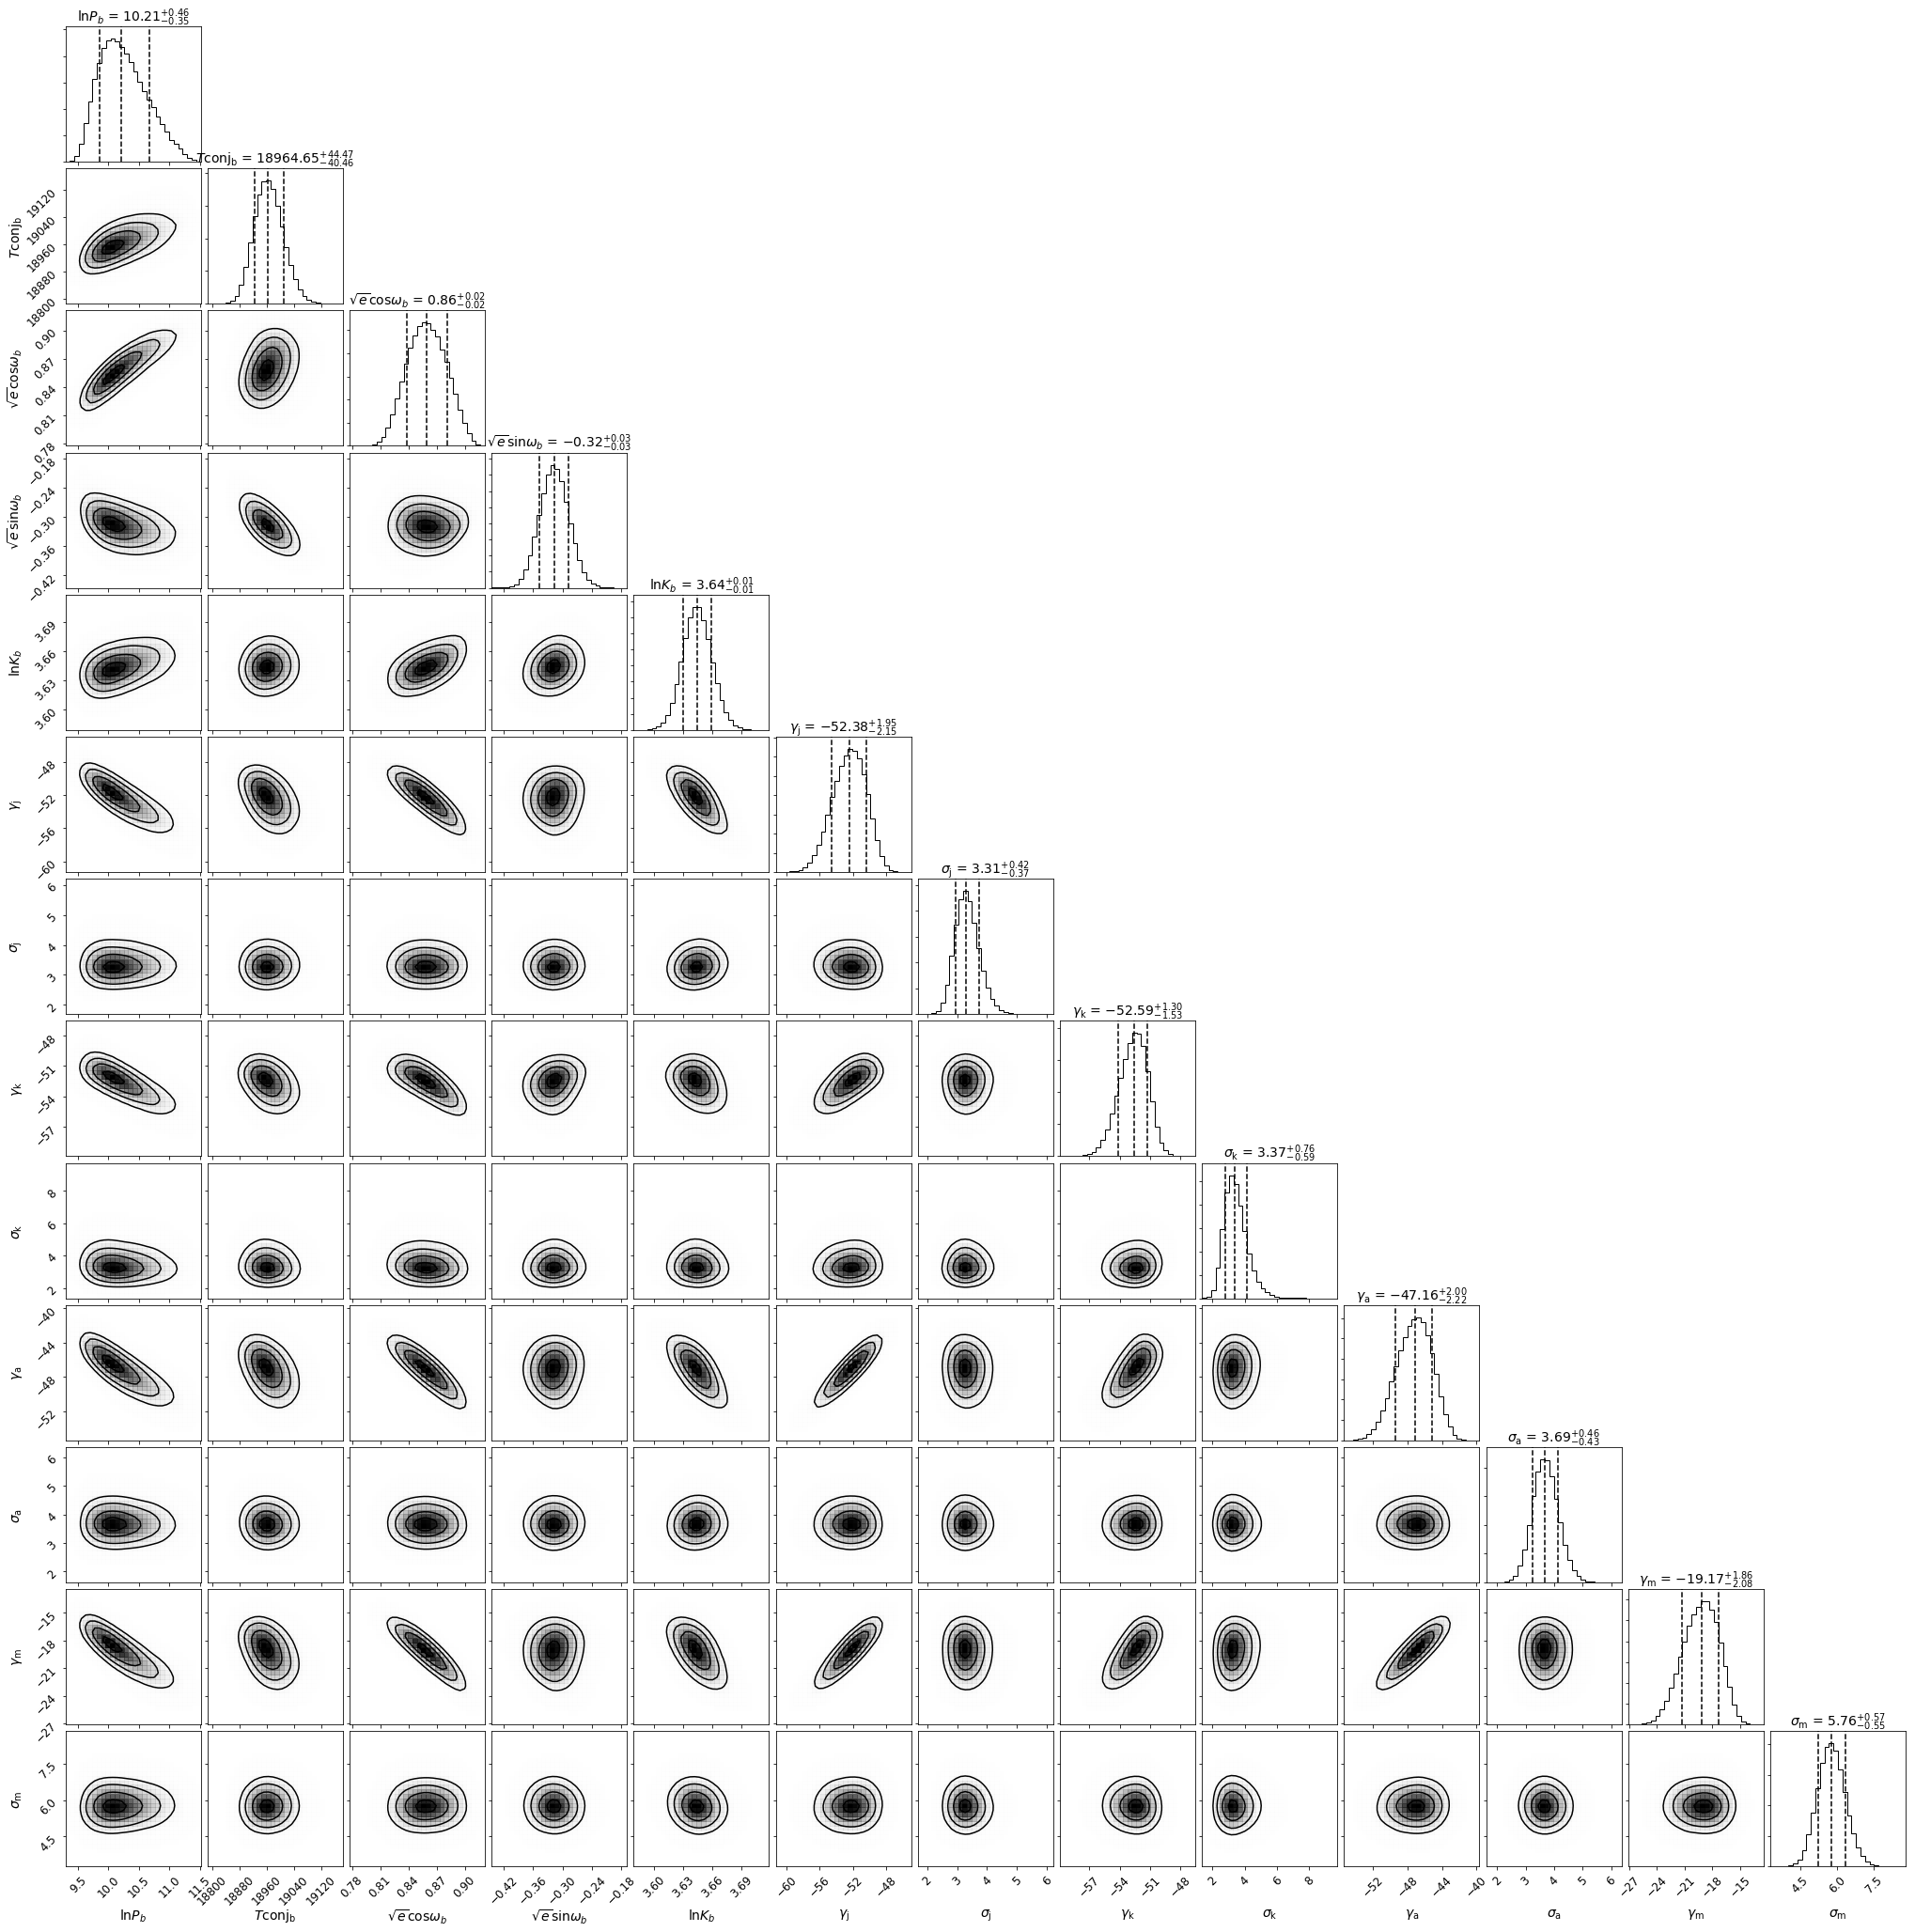

In [7]:
rc('font',size=8)

# preview & save corner plot
saveas = todays_directory + '/120066_corner.pdf'

Corner = mcmc_plots.CornerPlot(post, df, saveplot= saveas)
Corner.plot()

### Prior Comparison Figure

In [8]:
# read in results from radvel runs using different period priors
linear_chains_file_name = os.path.join(
    os.environ['HOME'] + '/Dropbox/planet-pi/' 
    + today + '/linearP/','120066_chains.csv.tar.bz2'
)
log_chains_file_name = os.path.join(
    os.environ['HOME'] + '/Dropbox/planet-pi/' 
    + today + '/logP/','120066_chains.csv.tar.bz2'
)

# read in chains
linP_df = pd.read_csv(linear_chains_file_name, compression='bz2')
logP_df = pd.read_csv(log_chains_file_name, compression='bz2')

per_linP_yrs = linP_df.per1.values/365.25
per_logP_yrs = np.exp(logP_df.logper1.values)/365.25

In [9]:
# draw from normally distributed stellar mass & parallax distributions
mstar_for_logP_fit = mstar_measured + np.random.normal(scale=mstar_err, size=len(logP_df))

# also calculate msini and ecc from logP fit
logP_df = post.params.basis.to_synth(logP_df)
ecc_logP = logP_df.e1.values

msini_logP = radvel.utils.Msini(
    logP_df.k1.values, 
    logP_df.per1.values, 
    mstar_for_logP_fit, 
    ecc_logP, Msini_units='jupiter'
)

6.120167525773196


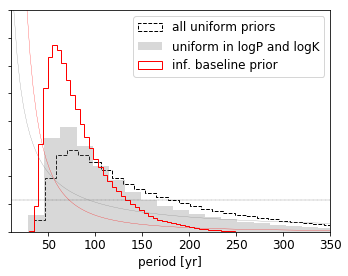

In [14]:
rc('font',size=12)

fig = plt.figure(figsize=(5,4))
n, bins, _ = plt.hist(per_linP_yrs, label='all uniform priors', bins=50, color='black', density=True, histtype='step', linestyle='--')
plt.hist(per_logP_yrs, label="uniform in logP and logK", bins=50, color='grey', density=True, alpha=.3)
plt.hist(per_yr, label='inf. baseline prior', bins=50, color='red', density=True, histtype='step')

plt.xlabel('period [yr]')
plt.tick_params(labelleft='off') 
plt.xlim([25,250])
plt.legend()
# plt.ylabel('P(d|m) $\propto$ p(m|d) p(m) \n                 $\propto$ exp(-$\chi^2$/2) p(m)')

max_yr = 350
plt.xlim(10,max_yr)
plt.ylim(0,.02)

# calculate & plot priors
num_pts = 100
yrs = np.linspace(10, max_yr, num_pts)
dt = yrs[1] - yrs[0]

uniform_prior = [np.median(n)]*num_pts
logP_prior = 0.1/yrs
inf_baseline_prior = 8./(yrs**2)
inf_baseline_prior[yrs <= 22.] = inf_baseline_prior[yrs > 22.][0]

plt.plot(yrs, uniform_prior/(np.sum(uniform_prior)*dt), color='k', linestyle='--', lw=0.25)
plt.plot(yrs, logP_prior/(np.sum(logP_prior)*dt), color='grey', lw=0.25)
plt.plot(yrs, inf_baseline_prior/(np.sum(inf_baseline_prior)*dt), color='red', lw=0.25)

fig.tight_layout()
plt.savefig(todays_directory + '/prior_comparison.pdf', dpi=250)

marginal_longp_prob = 100*len(per_yr[per_yr >= 150.])/len(per_yr)

print(marginal_longp_prob)

### Prior Comparison Table

In [50]:
def get_per_str(post):
    
    quantiles = np.quantile(post, [.16,.5,.84])
    line = '${}^{{+{}}}_{{-{}}}$'.format(
        format(quantiles[1], '.{}f'.format(0)),
        format(quantiles[2] - quantiles[1], '.{}f'.format(0)),
        format(quantiles[1] - quantiles[0], '.{}f'.format(0)),
    )
    
    return line

with open("{}/prior_comp.tex".format(todays_directory),"w+") as f: 
    line = 'uniform in P \\& K & {} yr \\\\'.format(get_per_str(per_linP_yrs))
    f.write(line)
    line = 'uniform in logP \\& logK & {} yr \\\\'.format(get_per_str(per_logP_yrs))
    f.write(line)
    line = 'inf. baseline prior (adopted) & {} yr \\\\'.format(get_per_str(per_yr))
    f.write(line)
f.close()

### Gamma Dot Model Comparison

In [32]:
gammadot_chains_file_name = os.path.join(
    os.environ['HOME'] + '/Dropbox/planet-pi/' 
    + today + '/dvdt/','120066_chains.csv.tar.bz2'
)

gammadot_df = pd.read_csv(gammadot_chains_file_name, compression='bz2')
dvdt_msyr = gammadot_df['dvdt']*365.25
per_gammadot = np.exp(gammadot_df['logper1'])/365.25
ecc_gammadot = np.sqrt(gammadot_df['secosw1']**2 + gammadot_df['sesinw1']**2)

In [33]:
# calculate BIC for gammadot model and adopted model
gammadot_post_file_name = os.path.join(
    os.environ['HOME'] + '/Dropbox/planet-pi/' 
    + today + '/dvdt/','120066_post_obj.pkl'
)

# read in posterior object
gammadot_post = radvel.posterior.load(gammadot_post_file_name)

gammadot_bic = gammadot_post.bic()
adopted_bic = post.bic()

gammadot_aic = gammadot_post.likelihood.aic()
adopted_aic = post.likelihood.aic()

deltabic = gammadot_bic - adopted_bic
deltaaic = gammadot_aic - adopted_aic

### S-values

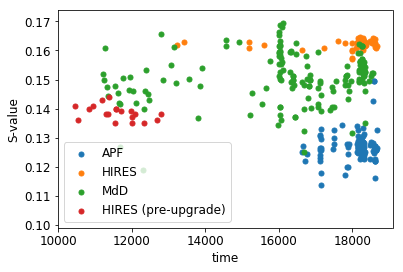

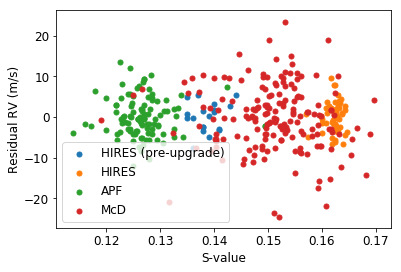

In [34]:
rc('font',size=12)

# plot S values vs time and vs residual values
fig = plt.figure()
plt.scatter(data_apf['time'], data_apf['SVAL'], label='APF')
plt.scatter(data_j['time'], data_j['SVAL'], label='HIRES')
plt.scatter(data_mcd['time'], data_mcd['SVAL'], label='MdD')
plt.scatter(data_k['time'], data_k['SVAL'], label='HIRES (pre-upgrade)')

plt.xlabel('time')
plt.ylabel('S-value')
plt.legend()

plt.savefig(todays_directory + '/120066_sval_vs_time.pdf', dpi=250)

fig = plt.figure()

for like in post.likelihood.like_list:
    if like.suffix == 'a':
        plt.scatter(data_apf['SVAL'], like.residuals(), label='APF')
    if like.suffix == 'j':
        plt.scatter(data_j['SVAL'], like.residuals(), label='HIRES')
    if like.suffix == 'k':
        plt.scatter(data_k['SVAL'], like.residuals(), label='HIRES (pre-upgrade)')
    if like.suffix == 'm':
        plt.scatter(data_mcd['SVAL'], like.residuals(), label='McD')

plt.xlabel('S-value')
plt.ylabel('Residual RV (m/s)')
plt.legend()

plt.savefig(todays_directory + '/120066_sval_vs_resids.pdf', dpi=250)

### Solar System Comparison Plot

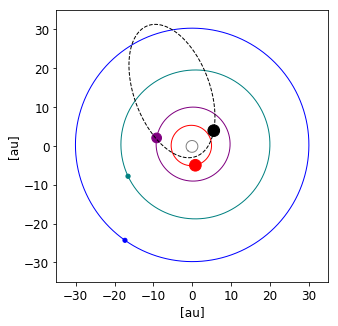

In [35]:
solarsytem_df = pd.read_csv('data/solarsystem_params.csv', comment='#')

start_mjd = 57388. # 1-1-2016
epochs = np.linspace(start_mjd,start_mjd+1e5,int(1e5))

_ = plt.figure(figsize=(5,5))
rc('font',size=12)

ax = plt.gca()
ax.set_aspect('equal', 'box')

linewidth = 1
colors = ['grey', 'red', 'purple', 'teal', 'blue']
jupiter_radius_ratios = [0., 1., .8329, .36278, .35219]
jupiter_mass_ratios = [0., 1., .29941, .0457346, .053953]

for i in np.arange(len(solarsytem_df)-1):
    
    period = (solarsytem_df.sma.values[i]**(1.5))*365.25
    max_epoch_index = (np.abs(epochs - start_mjd - period)).argmin()
    
    raoff, deoff, vz = calc_orbit(
        epochs[0:max_epoch_index+1], solarsytem_df.sma.values[i], solarsytem_df.ecc.values[i], 
        np.radians(solarsytem_df.i.values[i]), np.radians(solarsytem_df.omega.values[i]), 
        np.radians(solarsytem_df.Omega.values[i]), solarsytem_df.L.values[i]/360., 1.0, 1.0
    )
          
    plt.plot(raoff, deoff, color=colors[i], linewidth=linewidth, label=solarsytem_df.Name.values[i], zorder=1)
    circle = plt.Circle(
        (raoff[0], deoff[0]),
        1.5*jupiter_radius_ratios[i],
        color=colors[i]
    )
    ax.add_artist(circle)

max_epoch_index = (np.abs(epochs - start_mjd - per_map_days)).argmin()    

raoff, deoff, vz = calc_orbit(
    epochs[0:max_epoch_index+1], sma_map, ecc_map, 
    0., omega_pl_map_rad,
    0., tp_mjd_map/per_map_days,
    1.0, mstar_measured
)

circle = plt.Circle(
    (raoff[0], deoff[0]),
    1.5,
    color='k'
)
ax.add_artist(circle)

ax.plot(raoff, deoff, color='black', linewidth=linewidth, label='HR 5183 b', linestyle='--')

circle.set_label('inner solar system')

plt.xlabel('[au]'); plt.ylabel('[au]')
plt.xlim(-35,35); plt.ylim(-35,35)

plt.savefig(todays_directory + '/120066_solarsystem_compare.pdf', dpi=250)

### Derived Parameters Corner Plot

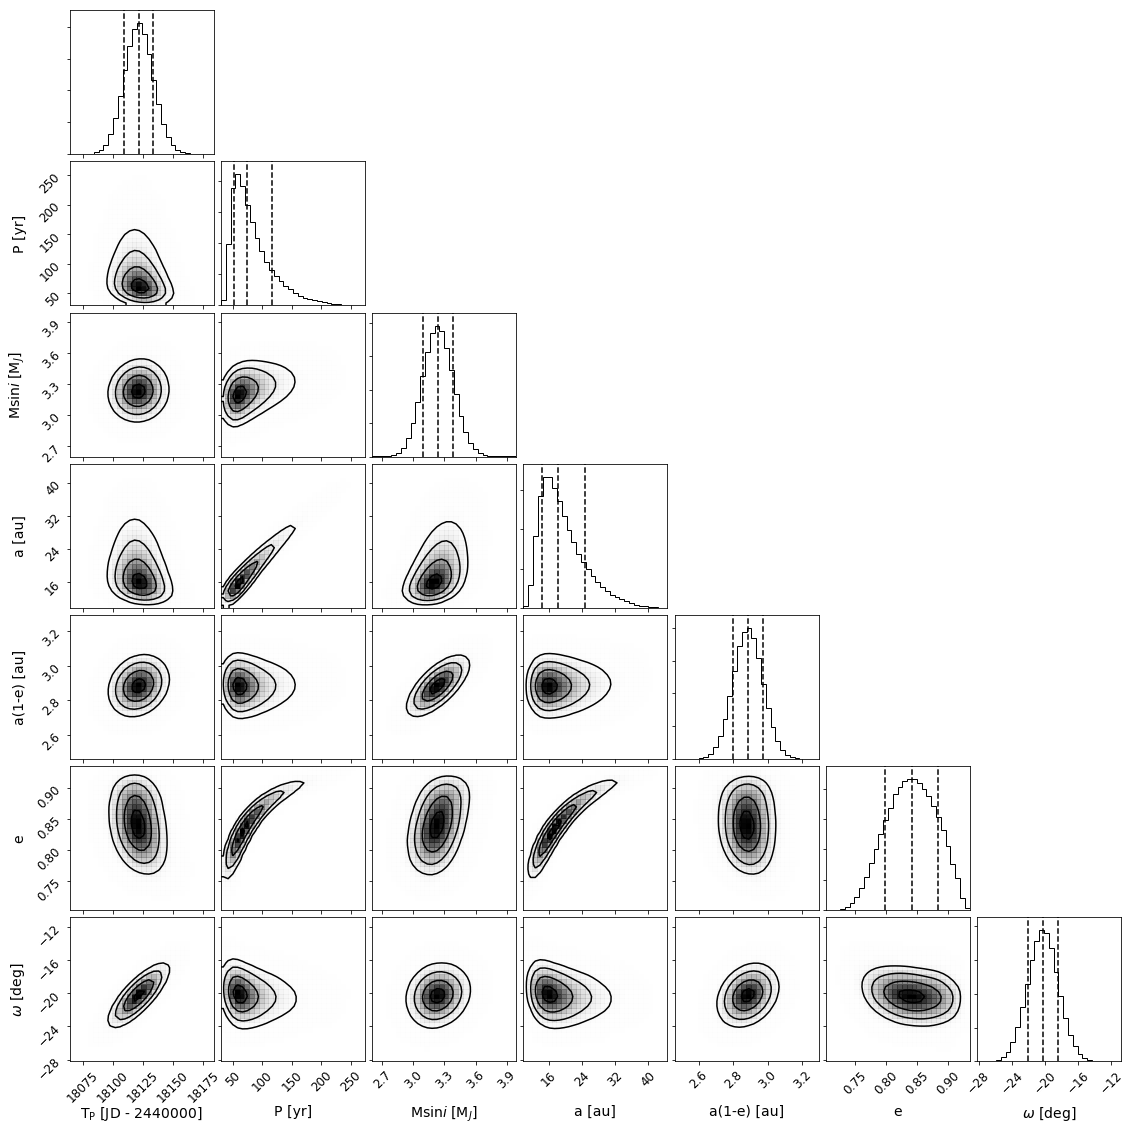

In [36]:
# make a corner plots of the derived parameters
f = rcParams['font.size']
rcParams['font.size'] = 12

to_plot = np.zeros((chain_length,7))
to_plot[:,0] = tp
to_plot[:,1] = per_yr
to_plot[:,2] = msini
to_plot[:,3] = sma
to_plot[:,4] = peri_dist
to_plot[:,5] = ecc
to_plot[:,6] = omega_deg

_ = corner.corner(
    to_plot, labels=[
        "T$_{\\rm P}$ [JD - 2440000]","P [yr]","M$\\sini$ [M$_J$]","a [au]", "a(1-e) [au]", "e", "$\\omega$ [deg]"
    ],
    label_kwargs={"fontsize": 14}, 
    plot_datapoints=False, bins=30, quantiles=[0.16, 0.50, 0.84],
    smooth=True
)

saveas = todays_directory + '/120066_derived.pdf'

plt.savefig(saveas, dpi=250)

rcParams['font.size'] = f

## Separation Prediction

### Compute Params Relevant to Rest of Notebook

In [37]:
tau, _ = np.modf(tp_mjd / per_days)
lan = np.random.random(size=len(sma))*2.*np.pi
cosi = (2.*np.random.random(size=len(sma))) - 1.
inc = np.arccos(cosi) 
mplanet_jup = msini / np.sin(inc)
mplanet_sol = msini*mjup2msun / np.sin(inc)

Probability that 120066 b is beyond 200 mas on 2020-01-01 00:00:00 : 0.06167686855670103
Probability that 120066 b is beyond 200 mas on 2023-01-01 00:00:00 : 0.6871955541237114
Probability that 120066 b is beyond 200 mas on 2024-01-01 00:00:00 : 0.9845956829896907


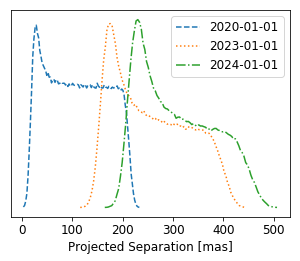

In [38]:
# make a histogram of predicted separations on a given date
def predict_sep(epoch_of_interest, plot_results=True, num2predict=len(sma), linestyle='--'):
    """
    Args:
        epoch_of_interest (array of astropy.Time): array of length 1; date 
            at which we want to predict the separation
        plot_results (Bool): whether or not to make a plot of the results (default: True)
        num2predict (int): number of separations to return
    """
    epoch = epoch_of_interest.jd - 2400000.5
    
    # returns raoff, deoff in mas
    raoff, deoff, vz = calc_orbit(
        epoch, sma[0:num2predict], 
        ecc[0:num2predict],
        inc[0:num2predict], 
        omega_pl_rad[0:num2predict], 
        lan[0:num2predict], 
        tau[0:num2predict], 
        parallax[0:num2predict], mstar[0:num2predict]
    )

    sep = np.sqrt(raoff**2 + deoff**2)
    
    if plot_results:
        n, bins = np.histogram(sep,bins=100,density=True)
        plt.plot(bins[1:] - 0.5*(bins[1]-bins[0]), n, label=str(epoch_of_interest)[:-9], linestyle=linestyle)
        plt.yticks([])
        plt.xlabel('Projected Separation [mas]')
        plt.legend()
    
    return sep

def calculate_prob(sep, epoch, linestyle='--'):
    """
    Calculate & print the probability that the planet will be beyond
    `sep` (") at `epoch`
    """
    calculated_seps = predict_sep(epoch, linestyle=linestyle)
    prob = len(calculated_seps[calculated_seps>=sep])/len(calculated_seps)
    print("Probability that 120066 b is beyond {} mas on {} : {}".format(sep, epoch, prob))
    return prob

hst_dates = [
    Time(datetime.datetime(2004, 6, 5, 0, 0, 0),format='datetime'),
    Time(datetime.datetime(2011, 2, 22, 0, 0, 0),format='datetime'),
    Time(datetime.datetime(2011, 5, 3, 0, 0, 0),format='datetime'),
    Time(datetime.datetime(2017, 3, 26, 0, 0, 0),format='datetime'),
    Time( datetime.datetime(2017, 7, 28, 0, 0, 0),format='datetime')
]


_ = plt.figure(figsize=(5,3.8))
rc('font',size=12)

_ = calculate_prob(200, Time(datetime.datetime(2020, 1, 1),format='datetime'))
_ = calculate_prob(200, Time(datetime.datetime(2023, 1, 1),format='datetime'), linestyle=':')
_ = calculate_prob(200, Time(datetime.datetime(2024, 1, 1),format='datetime'), linestyle='-.')

plt.xlim()

savefig(todays_directory + '/120066_separation_predictions.pdf', dpi=250)

### Lambertian Contrast Prediction

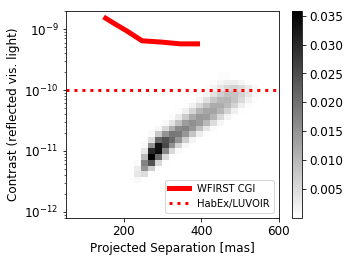

In [39]:
wfirst_launch = Time(2025.0, format='decimalyear') # estimated WFIRST launch date

wfirst_separations = predict_sep(wfirst_launch, plot_results=False)

proj_sep = wfirst_separations/parallax # [au]

flux_ratios, phase_angs = lambc.calculate_lambertian_contrast(
    wfirst_launch, sma, ecc, omega_pl_rad, inc, tau, mstar, proj_sep
)

counts, xbins, log_ybins = np.histogram2d(wfirst_separations, np.log10(flux_ratios), bins=20)
ybins=10**(log_ybins)
counts = np.ma.masked_where(counts==0, counts)
cmap = plt.cm.binary
cmap.set_bad(color='white')

fig, ax = plt.subplots(figsize=(5,3.8))
rc('font',size=12)

plt.pcolormesh(xbins, ybins, counts.T/np.sum(counts.T), cmap=cmap)

ax = plt.gca()
ax.set_yscale('log')

plt.xlabel('Projected Separation [mas]')
plt.ylabel('Contrast (reflected vis. light)')
cbar = plt.colorbar()

# read in predicted WFIRST imaging values
lambda_d, contrast = np.transpose(np.loadtxt('data/WFIRST_pred_imaging.txt'))[0:2]

D_wfirst = 2.4 # [m]
lambda_used = 575e-9 # [nm]

# calculate WFIRST contrast curve separations [mas]
sep = 1e3*rad2as*lambda_d*lambda_used/D_wfirst

plt.plot(sep, contrast, color='red', label='WFIRST CGI',linewidth=5)
plt.plot([.05*1e3, 2*1e3],[1e-10, 1e-10], label='HabEx/LUVOIR', color='red',linestyle=':',linewidth=3)

plt.legend(fontsize=10, loc='lower right')
plt.ylim(8e-13,2e-9)
plt.xlim(50,600)
fig.tight_layout()

plt.savefig(todays_directory + '/120066_vis_contrast_predictions.pdf', dpi=250)

### Thermal Contrast Prediction

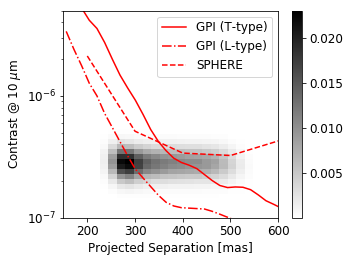

In [40]:
imaging_wavelen = 10.0*u.micron

thermal_cont_peri = (rjup2rsun/rstar)**2 * blackbody_lambda(imaging_wavelen, T_eq_peri)/blackbody_lambda(imaging_wavelen, st_teff)

elt_firstlight = Time(2025.0, format='decimalyear') # estimated ELT first light date
elt_separations = predict_sep(elt_firstlight, plot_results=False)

fig, ax = plt.subplots(figsize=(5,3.8))
ax.set_yscale('log')

rc('font',size=12)
cmap = plt.cm.binary
cmap.set_bad(color='white')
for contrast in [thermal_cont_peri]:

    counts, xbins, log_ybins = np.histogram2d(elt_separations, np.log10(contrast), bins=20)
    ybins=10**(log_ybins)

    counts = np.ma.masked_where(counts==0, counts)
    plt.pcolormesh(xbins, ybins, counts.T/np.sum(counts.T), cmap=cmap)

plt.xlabel('Projected Separation [mas]')
plt.ylabel('Contrast @ {} $\\mu$m'.format(int(imaging_wavelen.value)))
cbar = plt.colorbar()

# overplot GPI & SPHERE contrast
gpi_data = np.transpose(np.loadtxt('data/gpi_contrast_Ltype.txt'))
gpi_sep = gpi_data[0]*1e3 # [mas]
gpi_cont = gpi_data[2]

gpi_data_t = np.transpose(np.loadtxt('data/gpi_contrast_Ttype.txt'))
gpi_sep_t = gpi_data_t[0]*1e3 # [mas]
gpi_cont_t = gpi_data_t[2]

sphere_data = np.transpose(np.loadtxt('data/sphere_contrast.txt'))
sphere_sep = sphere_data[0]*1e3 # [mas]
sphere_cont = 10**(-sphere_data[1]/(100**(1/5))) # convert from delta mag to contrast

plt.plot(gpi_sep, gpi_cont, color='red', label='GPI (T-type)')
plt.plot(gpi_sep_t, gpi_cont_t, color='red', linestyle='-.', label='GPI (L-type)')#,linewidth=3)
plt.plot(sphere_sep, sphere_cont, color='red', linestyle='--', label='SPHERE')#,linewidth=3)
plt.xlim(150,600)
plt.ylim(1e-7,5e-6)
fig.tight_layout()

plt.legend()

plt.savefig(todays_directory + '/120066_ir_contrast_predictions.pdf', dpi=250)

### Gaia Prediction

In [41]:
start_date = radvel.date2jd(datetime.datetime(2015, 1, 1, 0, 0, 0)) - 2400000.5
end_date = radvel.date2jd(datetime.datetime(2022, 12, 31, 0, 0, 0)) - 2400000.5
n_epochs = 2000
gaia_epochs = np.linspace(start_date, end_date, n_epochs)

def predict_gaia_orbits(n_orbits):
    """
    Args:
        n_orbits (int): number of predicted Gaia orbits to plot
    """
    
    choose = np.random.randint(0, high=chain_length-1, size=n_orbits)
    
    # calculate orbits over the full orbital periods
    raoff = np.zeros((n_orbits, n_epochs))
    deoff = np.zeros((n_orbits, n_epochs))
    for i in np.arange(n_orbits):
        epochs = np.linspace(start_date, float(start_date+per_days[choose[i]]*1.001), n_epochs)
        ra_off, de_off, vz = calc_orbit(
            epochs, sma[choose[i]], ecc[choose[i]], inc[choose[i]], omega_pl_rad[choose[i]], lan[choose[i]], 
            tau[choose[i]], parallax[choose[i]], mstar[choose[i]]
        )
        raoff[i,:] = ra_off
        deoff[i,:] = de_off
    
    astrometric_ra = np.zeros((n_orbits, n_epochs))
    astrometric_dec = np.zeros((n_orbits, n_epochs))

    for i in np.arange(n_epochs):
        astrometric_ra[:,i] = -raoff[:,i]*mplanet_sol[choose]/mstar[choose]
        astrometric_dec[:,i] = -deoff[:,i]*mplanet_sol[choose]/mstar[choose]
      
    # calculate orbits over the Gaia timescale
    raoff_partial = np.zeros((n_orbits, n_epochs))
    deoff_partial = np.zeros((n_orbits, n_epochs))
    for i in np.arange(n_orbits):
        ra_off, de_off, vz = calc_orbit(
            gaia_epochs, sma[choose[i]], ecc[choose[i]], inc[choose[i]], omega_pl_rad[choose[i]], lan[choose[i]],
            tau[choose[i]], parallax[choose[i]], mstar[choose[i]]
        )
        raoff_partial[i,:] = ra_off
        deoff_partial[i,:] = de_off
    
    astrometric_ra_partial = np.zeros((n_orbits, n_epochs))
    astrometric_dec_partial = np.zeros((n_orbits, n_epochs))

    for i in np.arange(n_epochs):
        astrometric_ra_partial[:,i] = -raoff_partial[:,i]*mplanet_sol[choose]/mstar[choose]
        astrometric_dec_partial[:,i] = -deoff_partial[:,i]*mplanet_sol[choose]/mstar[choose]

        
    return astrometric_ra, astrometric_dec, astrometric_ra_partial, astrometric_dec_partial, mplanet_sol[choose]

ra, dec, ra_p, dec_p, mplanet_returned = predict_gaia_orbits(1000)

### Number of Orbits Detectable by Gaia

In [42]:
gaia_unc = .035 # current astrometric uncertainty on HR 5183 in Gaia catalogue [mas]

max_residual_array = np.empty(len(ra_p[:,0]))

# fit straight lines to all predicted orbits
for i in np.arange(len(ra_p[:,0])):
    ra_fit_vector = np.polyfit(gaia_epochs, ra_p[i,:], 1)
    dec_fit_vector = np.polyfit(gaia_epochs, dec_p[i,:], 1)
    
    ra_fit_coords = ra_fit_vector[1] + ra_fit_vector[0]*gaia_epochs
    dec_fit_coords = dec_fit_vector[1] + dec_fit_vector[0]*gaia_epochs
    
    # subtract orbit from straight line fit, take absolute value
    resids_ra = np.abs(ra_p[i,:] - ra_fit_coords)
    resids_dec = np.abs(dec_p[i,:] - dec_fit_coords)
    
    # get maximum absolute distance from straight line fit
    max_ra_resid = np.max(resids_ra)
    max_dec_resid = np.max(resids_dec)
    max_resid = np.max([max_ra_resid,max_dec_resid])
    max_residual_array[i] = max_resid
    
# if maximum distance in RA or Dec is more than 5xGaia uncertainty, count the orbit detectable by Gaia
detectable_indices = np.where(max_residual_array >= 5.*gaia_unc)[0]
print(
    "Percentage of orbits detectable by Gaia = {}%".format(
        100.*float(len(detectable_indices))/float(len(ra_p[:,0]))
    )
)

gaia_detection_percentage = 100.*float(len(detectable_indices))/float(len(ra_p[:,0]))

Percentage of orbits detectable by Gaia = 100.0%


### Representative Gaia Orbits Plot

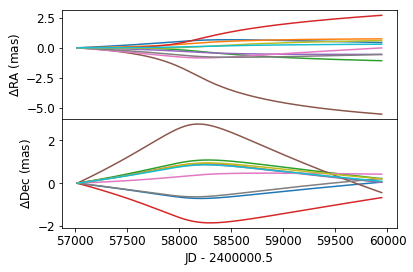

In [43]:
rcParams['font.size'] = 12

num2plot = 10

fig, ax = plt.subplots(2,1, sharex=True)
fig.subplots_adjust(hspace=0)    
    
# plot non-detectable orbits
for i in np.arange(len(ra_p[0:2*num2plot,0])):
    if i not in detectable_indices:
        ax[0].plot(gaia_epochs, ra_p[i,:] - ra_p[i,0], color='grey',  alpha=0.25)
        ax[1].plot(gaia_epochs, dec_p[i,:] - dec_p[i,0], color='grey', alpha=0.25)    

# plot detectable orbits
for num, i in enumerate(detectable_indices[0:num2plot]):
    ax[0].plot(gaia_epochs, ra_p[i,:] - ra_p[i,0])
    ax[1].plot(gaia_epochs, dec_p[i,:] - dec_p[i,0])
    
ax[0].set_ylabel('$\Delta$RA (mas)')
ax[1].set_ylabel('$\Delta$Dec (mas)')
ax[1].set_xlabel('JD - 2400000.5')

savefig(todays_directory + '/120066_gaia_detectable_orbits.pdf', dpi=250)

### Histogram of Gaia Residuals Plot

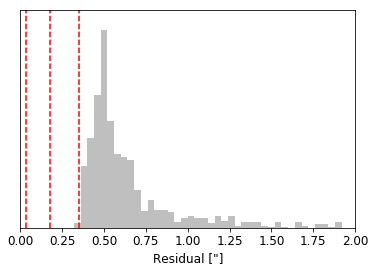

In [44]:
bins = 50

plt.figure(); ax = plt.gca()
vals, _, _ = plt.hist(max_residual_array, bins=bins, range=(0,2), color='grey', alpha=.5, density=True)
plt.xlim([0,2]); plt.ylim([0, 1.1*max(vals)])
plt.vlines(gaia_unc, linestyle='--', ymin=0, ymax=5*max(vals), color='red')
plt.vlines(5.*gaia_unc, linestyle='--', ymin=0, ymax=5*max(vals), color='red')
plt.vlines(10.*gaia_unc, linestyle='--', ymin=0, ymax=5*max(vals), color='red')
plt.xlabel('Residual ["]'); plt.yticks([])
savefig(todays_directory + '/120066_gaia_residuals.pdf', dpi=250)

### Fireworks Plot

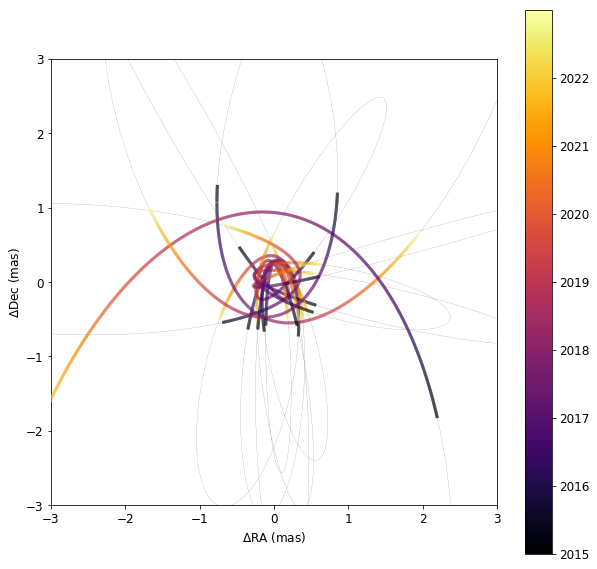

In [45]:
rcParams['font.size'] = 12

numorbits2plot = 15

fig = plt.figure(figsize=(10,10)); ax = plt.gca()
for i in np.arange(numorbits2plot):
    plt.plot(ra[i,:],dec[i,:], color='grey', linewidth=0.2)

norm = mpl.colors.Normalize(
    vmin=Time(gaia_epochs[0],format='mjd').decimalyear, 
    vmax=Time(gaia_epochs[-1],format='mjd').decimalyear
)

for i in np.arange(numorbits2plot):
    points = np.array([ra_p[i,:], dec_p[i,:]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(
        segments, norm=norm, linewidth=3.0, cmap=cm.inferno, zorder=3
    )
    lc.set_array(Time(gaia_epochs,format='mjd').decimalyear),
    ax.add_collection(lc)

ax.set_aspect('equal', 'box')
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_xlabel('$\Delta$RA (mas)')
ax.set_ylabel('$\Delta$Dec (mas)')
ax.locator_params(axis='x', nbins=6)
ax.locator_params(axis='y', nbins=6)
axcb = fig.colorbar(lc)

savefig(todays_directory + '/120066_gaia_predictions.pdf', dpi=250)

# Make Some Tables

### Print Nicely Formatted Values for Planet Params Table

In [47]:
def print_cmd(command_name, param_arr, ndecimals=2):

    quantiles = np.quantile(param_arr, [.16, .5, .84])

    if np.around(quantiles[1] - quantiles[0], ndecimals) == \
    np.around(quantiles[2] - quantiles[1], ndecimals):
        
        str2print = '${}\pm{}$'.format(
            format(quantiles[1], '.{}f'.format(ndecimals)),
            format(quantiles[1] - quantiles[0], '.{}f'.format(ndecimals))
        )
        
    else:
        
        str2print = '${}^{{+{}}}_{{-{}}}$'.format(
            format(quantiles[1], '.{}f'.format(ndecimals)),
            format(quantiles[2] - quantiles[1], '.{}f'.format(ndecimals)),
            format(quantiles[1] - quantiles[0], '.{}f'.format(ndecimals))
        )        
        
    return '\\newcommand{{\\{}}}{{{}}}'.format(command_name, str2print)

status_file = '{}/120066_radvel.stat'.format(todays_directory)
status = load_status(status_file)
nwalkers = status.getint('mcmc', 'nwalkers')
nensembles = status.getint('mcmc', 'nensembles')
nsteps = int(df.values.shape[0]/(8*nwalkers))
burnin = int(status.getfloat('mcmc', 'nsteps')) - nsteps
mintz = status.getfloat('mcmc', 'minTz')
maxGR = status.getfloat('mcmc', 'maxGR')
nobs_hires = len(data[(data.tel == 'j') | (data.tel == 'k')])
nobs_mcd = len(data[data.tel == 'm'])
nobs_apf = len(data[data.tel == 'a'])

msini_str = print_cmd('msini', msini)
per_str = print_cmd('period', per_yr, ndecimals=0)
aop_str = print_cmd('aop', omega_rad, ndecimals=2) 
per_d_str = print_cmd('perioddays', per_days, ndecimals=0)
k_str = print_cmd('semiamp', semiamp)
ecc_str = print_cmd('ecc', ecc)
tp_str = print_cmd('tp', tp_mjd, ndecimals=0)
sma_str = print_cmd('sma', sma, ndecimals=0)
approach_str = print_cmd('closestapproach', peri_dist)
teq_peri_str = print_cmd('teqperi', T_eq_peri, ndecimals=1)
teq_apo_str = print_cmd('teqapo', T_eq_apo, ndecimals=1)
phase_ang_str = print_cmd('phaseang', np.degrees(phase_angs), ndecimals=0)

msini_logP_str = print_cmd('msinilogP', msini_logP, ndecimals=2)
ecc_logP_str = print_cmd('ecclogP', ecc_logP, ndecimals=2)

tc_str = print_cmd('tconj', df['tc1'].values, ndecimals=0)  
sesinw_str = print_cmd('sesinw', df['sesinw1'].values)  
secosw_str = print_cmd('secosw', df['secosw1'].values)  
logK_str = print_cmd('logK', df['logk1'].values)  
logper_str = print_cmd('logper', df['logper1'].values)  
transitprob_str = print_cmd('transitprob', transit_prob, ndecimals=5)

gammaK_str = print_cmd('gammaK', df['gamma_k'].values, ndecimals=1)    
gammaJ_str = print_cmd('gammaJ', df['gamma_j'].values, ndecimals=1)    
gammaM_str = print_cmd('gammaM', df['gamma_m'].values, ndecimals=1)      
gammaA_str = print_cmd('gammaA', df['gamma_a'].values, ndecimals=1)     
jitK_str = print_cmd('jitK', df['jit_k'].values, ndecimals=1)      
jitJ_str = print_cmd('jitJ', df['jit_j'].values, ndecimals=1)      
jitM_str = print_cmd('jitM', df['jit_m'].values, ndecimals=1)    
jitA_str = print_cmd('jitA', df['jit_a'].values, ndecimals=1)    
dvdt_str = print_cmd('gammadot', dvdt_msyr)
dvdt_per_str = print_cmd('gammadotper', per_gammadot)
dvdt_ecc_str = print_cmd('gammadotecc', ecc_gammadot)

print(msini_logP_str)
print(ecc_logP_str)
print(msini_str)
print(aop_str)
print(transitprob_str)
print(per_str)
print(gammaK_str)
print(gammaJ_str)
print(gammaM_str)
print(gammaA_str)
print(jitK_str)
print(jitJ_str)
print(jitM_str)
print(jitA_str)
print(logper_str)
print(tc_str)
print(sesinw_str)
print(secosw_str)
print(logK_str)
print(per_d_str)
print(k_str)
print(ecc_str)
print(tp_str)
print(sma_str)
print(approach_str)
print(teq_peri_str)
print(teq_apo_str)
print(phase_ang_str)
print(dvdt_str)
print(dvdt_per_str)
print(dvdt_ecc_str)
print('\\newcommand{{\\shortper}}{{{}}}'.format(np.int(np.median(df_synth['per1'])/365.25)))
print('\\newcommand{{\\nwalkers}}{{{}}}'.format(nwalkers))
print('\\newcommand{{\\nsteps}}{{{}}}'.format(nsteps))
print('\\newcommand{{\\nensembles}}{{{}}}'.format(nensembles))
print('\\newcommand{{\\burnin}}{{{}}}'.format(burnin))
print('\\newcommand{{\\maxGR}}{{{}}}'.format(np.round(maxGR,3)))
print('\\newcommand{{\\minTz}}{{{}}}'.format(np.round(mintz,1)))
print('\\newcommand{{\\nobshires}}{{{}}}'.format(nobs_hires))
print('\\newcommand{{\\nobsmcd}}{{{}}}'.format(nobs_mcd))
print('\\newcommand{{\\nobsapf}}{{{}}}'.format(nobs_apf))
print('\\newcommand{{\\hiresbaseline}}{{{}}}'.format(int((np.max(data_hires.time)-np.min(data_hires.time))/365.25)))
print('\\newcommand{{\\mcdbaseline}}{{{}}}'.format(int((np.max(data_mcd.time)-np.min(data_mcd.time))/365.25)))
print('\\newcommand{{\\mapperiod}}{{{}}}'.format(np.round(per_map_yr,2)))
print('\\newcommand{{\\mapecc}}{{{}}}'.format(np.round(ecc_map,2)))
print('\\newcommand{{\\maplogper}}{{{}}}'.format(np.round(post.maxparams['logper1'],2)))
print('\\newcommand{{\\maptc}}{{{}}}'.format(np.round(post.maxparams['tc1'],2)))
print('\\newcommand{{\\mapsecosw}}{{{}}}'.format(np.round(post.maxparams['secosw1'],2)))
print('\\newcommand{{\\mapsesinw}}{{{}}}'.format(np.round(post.maxparams['sesinw1'],2)))
print('\\newcommand{{\\maplogK}}{{{}}}'.format(np.round(post.maxparams['logk1'],2)))
print('\\newcommand{{\\mapjitK}}{{{}}}'.format(np.round(post.maxparams['jit_k'],2)))
print('\\newcommand{{\\mapjitJ}}{{{}}}'.format(np.round(post.maxparams['jit_j'],2)))
print('\\newcommand{{\\mapjitM}}{{{}}}'.format(np.round(post.maxparams['jit_m'],2)))
print('\\newcommand{{\\mapjitA}}{{{}}}'.format(np.round(post.maxparams['jit_a'],2)))
print('\\newcommand{{\\mapgammaA}}{{{}}}'.format(np.round(post.maxparams['gamma_a'],2)))
print('\\newcommand{{\\mapgammaJ}}{{{}}}'.format(np.round(post.maxparams['gamma_j'],2)))
print('\\newcommand{{\\mapgammaM}}{{{}}}'.format(np.round(post.maxparams['gamma_m'],2)))
print('\\newcommand{{\\mapgammaK}}{{{}}}'.format(np.round(post.maxparams['gamma_k'],2)))
print('\\newcommand{{\\mapK}}{{{}}}'.format(np.round(K_map,2)))
print('\\newcommand{{\\mapaop}}{{{}}}'.format(np.round(omega_map_rad,2)))
print('\\newcommand{{\\mapmsini}}{{{}}}'.format(np.round(msini_map,2)))
print('\\newcommand{{\\mapTp}}{{{}}}'.format(np.round(tp_mjd_map,0)))
print('\\newcommand{{\\mapa}}{{{}}}'.format(np.round(sma_map,0)))
print('\\newcommand{{\\mapclosestapproach}}{{{}}}'.format(np.round(peri_dist_map,2)))
print('\\newcommand{{\\mapteqperi}}{{{}}}'.format(np.round(map_T_eq_peri,2)))
print('\\newcommand{{\\mapteqapo}}{{{}}}'.format(np.round(map_T_eq_apo,2)))
print('\\newcommand{{\\deltabic}}{{{}}}'.format(np.round(deltabic,1)))
print('\\newcommand{{\\deltaaic}}{{{}}}'.format(np.round(deltaaic,1)))

\newcommand{\msinilogP}{$3.28^{+0.16}_{-0.15}$}
\newcommand{\ecclogP}{$0.87\pm0.05$}
\newcommand{\msini}{$3.23^{+0.15}_{-0.14}$}
\newcommand{\aop}{$-0.35\pm0.03$}
\newcommand{\transitprob}{$0.00185\pm0.00010$}
\newcommand{\period}{$74^{+43}_{-22}$}
\newcommand{\gammaK}{$-52.6^{+1.3}_{-1.5}$}
\newcommand{\gammaJ}{$-52.4^{+2.0}_{-2.1}$}
\newcommand{\gammaM}{$-19.2^{+1.9}_{-2.1}$}
\newcommand{\gammaA}{$-47.2^{+2.0}_{-2.2}$}
\newcommand{\jitK}{$3.4^{+0.8}_{-0.6}$}
\newcommand{\jitJ}{$3.3\pm0.4$}
\newcommand{\jitM}{$5.8^{+0.6}_{-0.5}$}
\newcommand{\jitA}{$3.7^{+0.5}_{-0.4}$}
\newcommand{\logper}{$10.21^{+0.46}_{-0.35}$}
\newcommand{\tconj}{$18965^{+44}_{-40}$}
\newcommand{\sesinw}{$-0.32\pm0.03$}
\newcommand{\secosw}{$0.86\pm0.02$}
\newcommand{\logK}{$3.64\pm0.01$}
\newcommand{\perioddays}{$27060^{+15682}_{-7972}$}
\newcommand{\semiamp}{$38.25^{+0.58}_{-0.55}$}
\newcommand{\ecc}{$0.84\pm0.04$}
\newcommand{\tp}{$58121\pm12$}
\newcommand{\sma}{$18^{+6}_{-4}$}
\newcommand{\closestapproach}{$2.

### Table of Measurements

In [48]:
print_data = data.sort_values("time")
print_data = print_data.reset_index(drop=True)

print_data.tel[print_data.tel == 'm'] = 'TULL'
print_data.tel[print_data.tel == 'j'] = 'HIRES'
print_data.tel[print_data.tel == 'k'] = 'HIRES \\tablenotemark{a}'  # pre-upgrade
print_data.tel[print_data.tel == 'a'] = 'APF'

print_data.SVAL[np.isnan(print_data.SVAL)] = "---\\xspace"
print_data.sval_err[np.isnan(print_data.sval_err)] = "---\\xspace"

print_data.sval_err[print_data.tel == 'APF'] = 0.004
print_data.sval_err[print_data.tel == 'HIRES'] = 0.002

with open("{}/rvs.tex".format(todays_directory),"w+") as f:
    with open("{}/rvs_truncated.tex".format(todays_directory),"w+") as f1:
        for i in np.arange(len(print_data)):
            sval_round = 2
            try:
                if print_data.tel[i] == 'APF' or print_data.tel[i] == 'HIRES':
                      sval_round = 3      
                sval = np.round(print_data.SVAL[i], sval_round)
                sval_err = np.round(print_data.sval_err[i], sval_round)
            except TypeError:
                sval = print_data.SVAL[i]
                sval_err = print_data.sval_err[i]
            line = "${}$ & ${}$ & ${}$ & {} & {} & {}\\\ \n".format(
                np.round(print_data.time[i],4),
                np.round(print_data.mnvel[i],2),
                np.round(print_data.errvel[i],2),
                print_data.tel[i],
                sval,
                sval_err
            )
            f.write(line)
            if i<10:
                f1.write(line)
f1.close()
f.close()

# Copy Everything to Overleaf

In [15]:
_ = os.system("cp {}/*.pdf {}/Dropbox/Apps/Overleaf/120066/plots".format(todays_directory,os.environ['HOME']))
_ = os.system("cp {}/*.tex {}/Dropbox/Apps/Overleaf/120066/tables".format(todays_directory,os.environ['HOME']))